# SQLAlchemy Challenge

### Dependencies and Setup

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pylab import rcParams
import scipy.stats as stats
import gmaps
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta
import dateutil.parser
import warnings

sns.set()
warnings.filterwarnings('ignore')
plt.rc('lines', linewidth=1)
rcParams['figure.figsize'] = 12,6
pd.set_option('display.max_colwidth', 40)
pd.options.display.float_format = '{:,.2f}'.format

## Database Connection

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import *

In [3]:
# reflect an existing database into a new model
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
# Use the Base class to reflect the database tables
Base = automap_base()
Base.prepare(engine, reflect=True)
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

## Measurements Dataset Overview

In [4]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station
# Create our session (link) from Python to the DB
session = Session(engine)
for measure in session.query(measurement).limit(10):
    print(measure.id, measure.station, measure.date, measure.prcp, measure.tobs)

1 USC00519397 2010-01-01 0.08 65.0
2 USC00519397 2010-01-02 0.0 63.0
3 USC00519397 2010-01-03 0.0 74.0
4 USC00519397 2010-01-04 0.0 76.0
5 USC00519397 2010-01-06 None 73.0
6 USC00519397 2010-01-07 0.06 70.0
7 USC00519397 2010-01-08 0.0 64.0
8 USC00519397 2010-01-09 0.0 68.0
9 USC00519397 2010-01-10 0.0 73.0
10 USC00519397 2010-01-11 0.01 64.0


In [5]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)
# Collect the names of tables within the database
table_1 = inspector.get_table_names()[0]
# Using the inspector to print the column names within the 'dow' table and its types
columns = inspector.get_columns(table_1)
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [6]:
# Reading DataSet to DataFrame with conversion text date column to date type
measurement = pd.read_sql('measurement', engine)
print(measurement.shape)
measurement['date'] = pd.to_datetime(measurement['date'])
measurement['year'] = pd.DatetimeIndex(measurement['date']).year
measurement['month'] = pd.DatetimeIndex(measurement['date']).month 
measurement

(19550, 5)


,id,station,date,prcp,tobs,year,month
0,1,USC00519397,2010-01-01,0.08,65.00,2010,1
1,2,USC00519397,2010-01-02,0.00,63.00,2010,1
2,3,USC00519397,2010-01-03,0.00,74.00,2010,1
3,4,USC00519397,2010-01-04,0.00,76.00,2010,1
4,5,USC00519397,2010-01-06,nan,73.00,2010,1
...,...,...,...,...,...,...,...
19545,19546,USC00516128,2017-08-19,0.09,71.00,2017,8
19546,19547,USC00516128,2017-08-20,nan,78.00,2017,8
19547,19548,USC00516128,2017-08-21,0.56,76.00,2017,8
19548,19549,USC00516128,2017-08-22,0.50,76.00,2017,8


## Mapping Stations

In [7]:
stations = pd.read_sql('station', engine)
print(stations.shape)
stations

(9, 6)


,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27,-157.82,3.00
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42,-157.80,14.60
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52,-157.84,7.00
3,4,USC00517948,"PEARL CITY, HI US",21.39,-157.98,11.90
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.50,-158.01,306.60
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.34,-157.71,19.50
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45,-157.85,32.90
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.32,-158.00,0.90
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33,-157.80,152.40


In [8]:
stat_geo = stations[['latitude', 'longitude']]
data_station_maplist = []
for row in stations.itertuples():
    data_station_maplist.append(
        {'name': row.station, 'address': row.name, 'elevation': row.elevation})
data_station_maplist

[{'name': 'USC00519397', 'address': 'WAIKIKI 717.2, HI US', 'elevation': 3.0},
 {'name': 'USC00513117', 'address': 'KANEOHE 838.1, HI US', 'elevation': 14.6},
 {'name': 'USC00514830',
  'address': 'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  'elevation': 7.0},
 {'name': 'USC00517948', 'address': 'PEARL CITY, HI US', 'elevation': 11.9},
 {'name': 'USC00518838',
  'address': 'UPPER WAHIAWA 874.3, HI US',
  'elevation': 306.6},
 {'name': 'USC00519523',
  'address': 'WAIMANALO EXPERIMENTAL FARM, HI US',
  'elevation': 19.5},
 {'name': 'USC00519281', 'address': 'WAIHEE 837.5, HI US', 'elevation': 32.9},
 {'name': 'USC00511918',
  'address': 'HONOLULU OBSERVATORY 702.2, HI US',
  'elevation': 0.9},
 {'name': 'USC00516128',
  'address': 'MANOA LYON ARBO 785.2, HI US',
  'elevation': 152.4}]

In [9]:
info_box_template = """
<dl>
<dt>Station Name</dt><dd>{name}</dd>
<dt>Station Address</dt><dd>{address}</dd>
<dt>Elevation</dt><dd>{elevation}</dd>
</dl>
"""
station_info = [info_box_template.format(**station) for station in data_station_maplist]
marker_layer = gmaps.marker_layer(stat_geo, info_box_content=station_info)
fig = gmaps.figure()
fig.add_layer(marker_layer)
fig

Figure(layout=FigureLayout(height='420px'))

![presentation_slide](images/hawai_map.png)

## Recommended Statistical Analysis
#### Temperature Analysis I

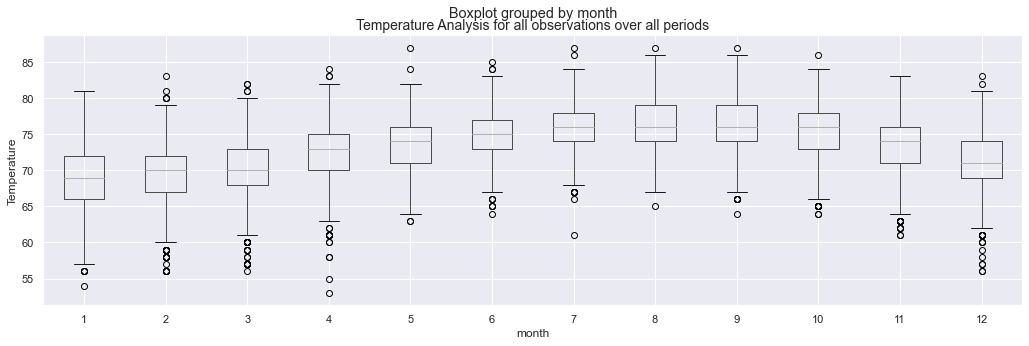

In [10]:
# Create Avg Tempearture Overview for 12 months
_=measurement.boxplot("tobs", by="month", figsize=(17, 5))
_=plt.title("Temperature Analysis for all observations over all periods", size=14)
_= plt.ylabel('Temperature')

In [11]:
# Create average month temperature observations
avg_temp = measurement.groupby('month').agg({'tobs':'mean'}).rename(columns={'tobs':'Avg Month Temp'})
avg_temp

,Avg Month Temp
month,
1,68.73
2,69.44
3,70.06
4,72.36
5,73.68
6,74.94
7,76.08
8,76.41
9,76.16


In [12]:
# Creating December DataSet for temperature observations
december_data = measurement[measurement['month']==12]
december_data.describe()

,id,prcp,tobs,year,month
count,"1,517.00","1,405.00","1,517.00","1,517.00","1,517.00"
mean,"9,816.71",0.22,71.04,"2,012.88",12.00
std,"5,658.32",0.54,3.75,1.98,0.00
min,306.00,0.00,56.00,"2,010.00",12.00
25%,"4,840.00",0.00,69.00,"2,011.00",12.00
50%,"9,876.00",0.03,71.00,"2,013.00",12.00
75%,"14,717.00",0.15,74.00,"2,015.00",12.00
max,"19,328.00",6.42,83.00,"2,016.00",12.00


In [13]:
# Creating June DataSet for temperature observations
june_data = measurement[measurement['month']==6]
june_data.describe()

,id,prcp,tobs,year,month
count,"1,700.00","1,574.00","1,700.00","1,700.00","1,700.00"
mean,"9,752.65",0.14,74.94,"2,013.34",6.00
std,"5,617.51",0.34,3.26,2.29,0.00
min,134.00,0.00,64.00,"2,010.00",6.00
25%,"5,020.75",0.00,73.00,"2,011.00",6.00
50%,"9,673.50",0.02,75.00,"2,013.00",6.00
75%,"14,547.25",0.12,77.00,"2,015.00",6.00
max,"19,497.00",4.43,85.00,"2,017.00",6.00


In [14]:
# Removing 2017 year to keep data consistency
june_data.drop(june_data[june_data.year == 2017].index, inplace=True)
june_data.describe()

,id,prcp,tobs,year,month
count,"1,509.00","1,403.00","1,509.00","1,509.00","1,509.00"
mean,"9,696.70",0.14,74.66,"2,012.88",6.00
std,"5,629.58",0.35,3.22,2.00,0.00
min,134.00,0.00,64.00,"2,010.00",6.00
25%,"4,691.00",0.00,72.00,"2,011.00",6.00
50%,"9,682.00",0.02,75.00,"2,013.00",6.00
75%,"14,537.00",0.11,77.00,"2,015.00",6.00
max,"19,152.00",4.43,85.00,"2,016.00",6.00


In [15]:
# Delete last 8 rows to make datasets length equal
december_data = december_data.iloc[:-8]
december_data.describe()

,id,prcp,tobs,year,month
count,"1,509.00","1,397.00","1,509.00","1,509.00","1,509.00"
mean,"9,766.30",0.21,71.05,"2,012.87",12.00
std,"5,630.66",0.54,3.75,1.98,0.00
min,306.00,0.00,56.00,"2,010.00",12.00
25%,"4,838.00",0.00,69.00,"2,011.00",12.00
50%,"9,872.00",0.03,71.00,"2,013.00",12.00
75%,"14,711.00",0.14,74.00,"2,014.00",12.00
max,"19,320.00",6.42,83.00,"2,016.00",12.00


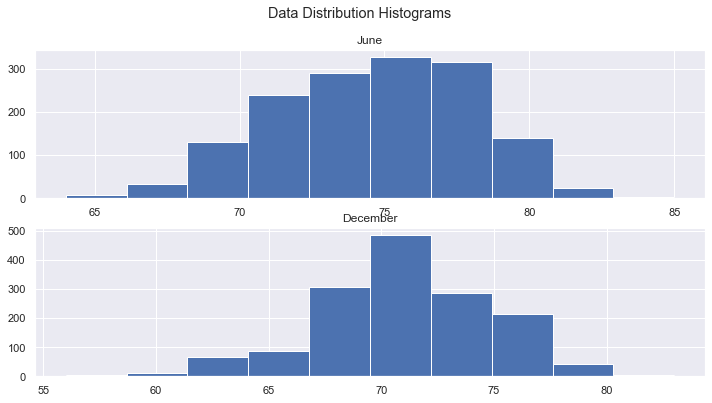

In [16]:
# Checking data normality
fig, axs = plt.subplots(2)
_=fig.suptitle('Data Distribution Histograms')
_=axs[0].hist(june_data['tobs'])
_=axs[0].set_title('June')
_=axs[1].hist(december_data['tobs'])
_=axs[1].set_title('December')

In [17]:
# Shapiro-Wilk test for June dataset
stats.shapiro(june_data['tobs'])

(0.982990026473999, 2.314020936672323e-12)

In [18]:
# Shapiro-Wilk test for December dataset
stats.shapiro(december_data['tobs'])

(0.9841665029525757, 8.13265167015631e-12)

* Both of the datasets violate the assumption of normality by a large amount. 
* However, for assignment purposes, I shall continue with using the paired sample t-test

#### NULL HYPOTHESIS: There is no significant difference between June and December Datasets
#### ALTERNATIVE HYPOTHESIS: Translates to the mean difference between June and December is not equal to 0.

In [19]:
# Conducting a paired sample t-test
# A Paired sample t-test compares means from the same group at different times (6 and 12 monthes)
# (An Independent Samples t-test compares the means for two groups)
# (A One sample t-test tests the mean of a single group against a known mean)
stats.ttest_rel(june_data['tobs'], december_data['tobs'])

Ttest_relResult(statistic=31.752653814106903, pvalue=7.2369972334754e-170)

In [20]:
# Confirm result by doing ANOVA TEST
stats.f_oneway(june_data['tobs'], december_data['tobs'])

F_onewayResult(statistic=802.6090223166925, pvalue=9.327673335208355e-157)

* Based on the result with an F-test being much greater than 4 and the p-value being much lower than 0.05
* We reject the null hypothesis in support of alternative one
* The observation trend: Despite Hawaii is reputed to enjoy mild weather all year there is a significant difference between June and December Datasets
* Note: the findings from this analysis should not be considered valid due to the large violation of the assumption about normality.
* An appropriate alternative to use would be the Wilcoxon signed-rank Test

## Session Queries Climate Analysis

In [21]:
# Design a query to retrieve the last year and 1 month of previous year of precipitation data
# Use the session to query with date type
session = Session(engine)
date_conv = func.date(measurement.date, type_=Date)
stmt = session.query(func.date(measurement.date), measurement.prcp).\
                    filter((extract('year', date_conv) == 2017) |
                           ((extract('year', date_conv) == 2016) &
                           (extract('month', date_conv) == 12))).\
                    order_by(measurement.date.desc()).statement
data = pd.read_sql_query(stmt, session.bind)
data.shape

InvalidRequestError: SQL expression, column, or mapped entity expected - got '0       0.08
1       0.00
2       0.00
3       0.00
4        nan
        ... 
19545   0.09
19546    nan
19547   0.56
19548   0.50
19549   0.45
Name: prcp, Length: 19550, dtype: float64'

In [26]:
# Calculate the date 1 year ago from the last data point in the database
# Earliest Date
date_conv = func.date(measurement.date, type_=Date)
early_date = session.query(date_conv).order_by(date_conv).first()
early_date

(datetime.date(2010, 1, 1))

In [70]:
# Latest Date
latest_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
latest_date = datetime.strptime(latest_date[0], "%Y-%m-%d")

In [72]:
# Year Ago Date
year_ago = latest_date + dt.timedelta(days=-365)
year_ago

datetime.datetime(2016, 8, 23, 0, 0)

In [73]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
stmt = session.query(func.date(measurement.date).label('date'), measurement.prcp.label('precipitation')).\
                    filter(measurement.date > year_ago).\
                    order_by(measurement.date.desc()).statement
prcp_data = pd.read_sql_query(stmt, session.bind)
prcp_data = prcp_data.sort_values('date')
prcp_data.head(10)

,date,precipitation
2222,2016-08-24,1.45
2216,2016-08-24,0.08
2217,2016-08-24,2.15
2221,2016-08-24,2.15
2219,2016-08-24,nan
2218,2016-08-24,2.28
2220,2016-08-24,1.22
2215,2016-08-25,0.11
2214,2016-08-25,0.06
2213,2016-08-25,0.21


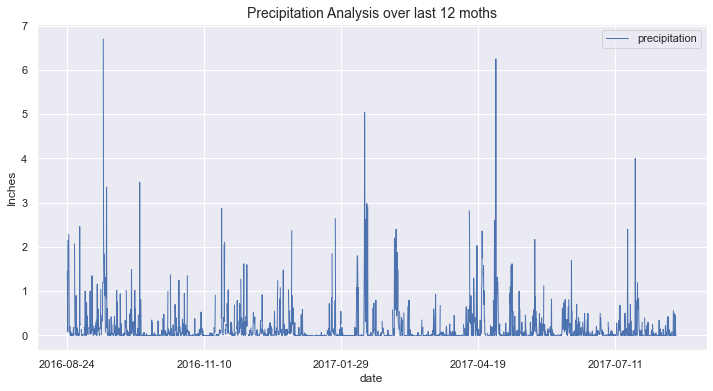

In [30]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_data.set_index('date').plot()
_=plt.title("Precipitation Analysis over last 12 moths", size=14)
_= plt.ylabel('Inches')

In [31]:
# Alternative query reading to DataFrame
# stmt = session.query(measurement.date, measurement.prcp).filter(measurement.date >= year_ago).all()
# df = pd.DataFrame(stmt, columns=["date", "precipitation"])

In [32]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_data.describe()

,precipitation
count,"2,015.00"
mean,0.18
std,0.46
min,0.00
25%,0.00
50%,0.02
75%,0.13
max,6.70


In [33]:
# Design a query to show how many stations are available in this dataset?
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stmt = session.query(measurement.station, func.count(measurement.station).label('total_number')).\
                    group_by(measurement.station).order_by(desc('total_number')).statement
prcp_station_data = pd.read_sql_query(stmt, session.bind)
active_station = prcp_station_data['station'][0]
print('Number of unique stations: ', len(prcp_station_data))
prcp_station_data

Number of unique stations:  9


,station,total_number
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [34]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
stmt = session.query(measurement.station, station.name, func.min(measurement.prcp).label('min_prcp'),
                    func.max(measurement.prcp).label('max_prcp'), func.avg(measurement.prcp).label('avg_prcp')).\
                    filter(measurement.station == station.station).\
                    group_by(measurement.station).filter(measurement.station == active_station).statement
active_station_data = pd.read_sql_query(stmt, session.bind)
active_station_data 

,station,name,min_prcp,max_prcp,avg_prcp
0,USC00519281,"WAIHEE 837.5, HI US",0.00,9.64,0.21


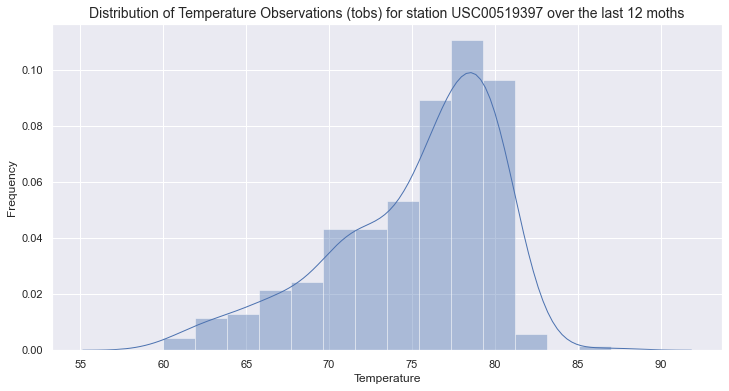

In [35]:
# Choose the station with the highest number of temperature observations
stmt = session.query(measurement.station, func.max(measurement.tobs).label('highest_number')).statement
tobs_data = pd.read_sql_query(stmt, session.bind)
tobs_station = tobs_data['station'][0]
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
stmt = session.query(func.date(measurement.date).label('date'), measurement.tobs.label('temp_observations')).\
                    filter(measurement.date > year_ago).filter(measurement.station == tobs_station).\
                    order_by(measurement.tobs.desc()).statement
tobs_station_data = pd.read_sql_query(stmt, session.bind)
tobs_station_data = tobs_station_data.set_index('date')
sns.distplot(tobs_station_data)
_=plt.title(f"Distribution of Temperature Observations (tobs) for station {tobs_station} over the last 12 moths", size=14)
_= plt.ylabel('Frequency')
_= plt.xlabel('Temperature')

## Recommended Bonus Analysis
#### Temperature Analysis II

In [82]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
start_trip = '2012-02-28'
end_trip = '2012-03-05'
print(calc_temps(start_trip, end_trip))

[(62.0, 69.57142857142857, 74.0)]


In [83]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_trip = datetime.strptime(start_trip, "%Y-%m-%d")
new_start_trip = start_trip + dt.timedelta(days=-365)
end_trip = datetime.strptime(end_trip, "%Y-%m-%d")
new_end_trip = end_trip + dt.timedelta(days=-365)
new_start_trip, new_end_trip
trip_temp = calc_temps(new_start_trip, new_end_trip)
trip_temp

[(61.0, 70.17021276595744, 75.0)]

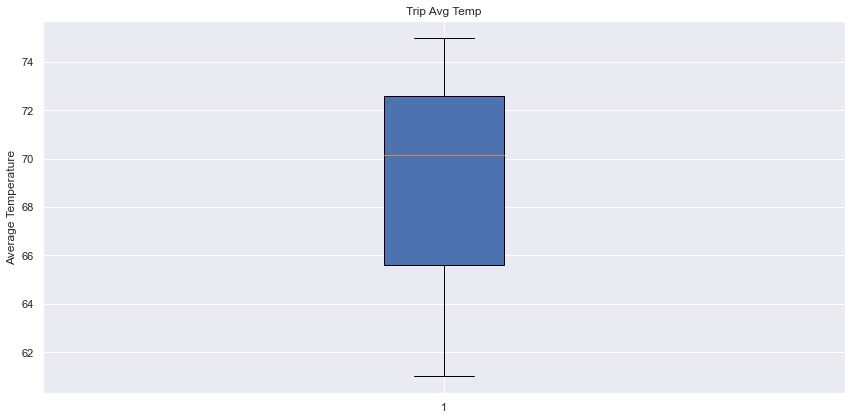

In [87]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
ptps = list(np.ravel(trip_temp))
fig, ax = plt.subplots()
x = range(len(ptps))
ax.boxplot(ptps, patch_artist=True)
ax.set_title('Trip Avg Temp')
ax.set_ylabel('Average Temperature', fontsize='medium') 
fig.tight_layout()
plt.show()

## Recommended Bonus Analysis
#### Daily Rainfall Average

In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session = Session(engine)
stmt = session.query(measurement.station, func.sum(measurement.prcp).label('tot_prcp'), station.name, station.latitude,
                     station.longitude, station.elevation).\
                    filter(measurement.station == station.station).group_by(measurement.station).\
                    filter((measurement.date >= new_start_trip) & (measurement.date <= new_end_trip) ).\
                    order_by(desc('tot_prcp')).statement
rainfall_data = pd.read_sql_query(stmt, session.bind)
rainfall_data 

InvalidRequestError: SQL expression, column, or mapped entity expected - got '0        USC00519397
1        USC00519397
2        USC00519397
3        USC00519397
4        USC00519397
            ...     
19545    USC00516128
19546    USC00516128
19547    USC00516128
19548    USC00516128
19549    USC00516128
Name: station, Length: 19550, dtype: object'

In [89]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# Create Data Frame with daily_normals
trip_pd = pd.DataFrame()
d_list = []
min_list = []
avg_list = []
max_list = []
for i in range(len(date_list)):
    y = date_list[i].strftime('%y')
    m = date_list[i].strftime('%m')
    d = date_list[i].strftime('%d')
    d_list.append(y + '-' + m + '-' + d)
    date_list[i] = m + '-' + d
    day_norm = daily_normals(date_list[i])[0]
    min_list.append(day_norm[0])
    avg_list.append(day_norm[1])
    max_list.append(day_norm[2])

# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_pd = pd.DataFrame({'Trip_Date': d_list, 'Temp_min': min_list,
                        'Temp_avg': avg_list, 'Temp_max': max_list})
trip_pd = trip_pd.set_index('Trip_Date')
print(trip_pd)

In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
ax = trip_pd.plot.area(stacked=False)
ax.set_title('Daily Rainfall Average over Trip Dates')
ax.set_ylabel('Temperature', fontsize='medium')
plt.show()